<a href="https://colab.research.google.com/github/lagom-QB/M11/blob/master/Practice_10_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation

In [0]:
from torchvision import models
from torch import nn
import torch
import torch.nn.functional as F
from pathlib import Path
import cv2
from torchvision import transforms
import numpy as np

In [0]:
class Identity(nn.Module):
  def forward(self, x):
    return x

In [0]:
class FlatChannel(nn.Module):
  def forward(self, x):
    batch_size = x.shape[0]
    width = x.shape[2]
    height = x.shape[3]
    return x.view(batch_size, x.shape[2], x.shape[3])

In [0]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, kernel_size=2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [0]:
def upsample_model():
  return nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,128),
    StdUpsample(128,64),
    StdUpsample(64,64),
    nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),
    FlatChannel()
  )

In [0]:
def fconv():
  backbone =  models.resnet18(pretrained=True)
  downsample = nn.Sequential(backbone.conv1, 
                             backbone.bn1, 
                             backbone.relu, 
                             backbone.maxpool,
                             backbone.layer1,
                             backbone.layer2,
                             backbone.layer3,
                             backbone.layer4)
  upsample = upsample_model()
  return nn.Sequential(downsample, upsample)

In [0]:
model = fconv()

In [0]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [0]:
test = torch.ones(4, 3, 64, 64)

In [0]:
model(test).shape

torch.Size([4, 64, 64])

In [0]:
!wget http://pages.cs.wisc.edu/~lizhang/projects/face-parsing/SmithCVPR2013_dataset_resized.zip

--2020-06-01 08:19:05--  http://pages.cs.wisc.edu/~lizhang/projects/face-parsing/SmithCVPR2013_dataset_resized.zip
Resolving pages.cs.wisc.edu (pages.cs.wisc.edu)... 128.105.7.26
Connecting to pages.cs.wisc.edu (pages.cs.wisc.edu)|128.105.7.26|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358268885 (342M) [application/zip]
Saving to: ‘SmithCVPR2013_dataset_resized.zip’

SmithCVPR2013_datas 100%[===================>] 341.67M  5.56MB/s    in 80s     

2020-06-01 08:20:27 (4.29 MB/s) - ‘SmithCVPR2013_dataset_resized.zip’ saved [358268885/358268885]



In [0]:
!unzip SmithCVPR2013_dataset_resized.zip

Streaming output truncated to the last 5000 lines.
  inflating: SmithCVPR2013_dataset_resized/labels/2945302269_1/2945302269_1_lbl04.png  
  inflating: SmithCVPR2013_dataset_resized/labels/2945302269_1/2945302269_1_lbl03.png  
  inflating: SmithCVPR2013_dataset_resized/labels/2945302269_1/2945302269_1_lbl02.png  
  inflating: SmithCVPR2013_dataset_resized/labels/2945302269_1/2945302269_1_lbl01.png  
  inflating: SmithCVPR2013_dataset_resized/labels/2945302269_1/2945302269_1_lbl00.png  
  inflating: SmithCVPR2013_dataset_resized/labels/2945300917_1/2945300917_1_lbl10.png  
  inflating: SmithCVPR2013_dataset_resized/labels/2945300917_1/2945300917_1_lbl09.png  
  inflating: SmithCVPR2013_dataset_resized/labels/2945300917_1/2945300917_1_lbl08.png  
  inflating: SmithCVPR2013_dataset_resized/labels/2945300917_1/2945300917_1_lbl07.png  
  inflating: SmithCVPR2013_dataset_resized/labels/2945300917_1/2945300917_1_lbl06.png  
  inflating: SmithCVPR2013_dataset_resized/labels/2945300917_1/294530

In [0]:
class FaceDataset(torch.utils.data.Dataset):
  def __init__(self, path: Path, transform):
    self._images_path = path / "images"
    self._labels_path = path / "labels"
    self._stems = list(map(lambda x: x.stem, self._images_path.glob("*")))
    self._transform = transform
    super().__init__()

  def __len__(self):
    return len(self._stems)
  
  def __getitem__(self, index: int):
    stem = self._stems[index]
    image_path = self._images_path / f"{stem}.jpg"
    label_path = self._labels_path / stem / f"{stem}_lbl00.png"
    image = cv2.imread(str(image_path))[:,:,::-1]
    label = 1 - cv2.imread(str(label_path), cv2.IMREAD_GRAYSCALE) // 255
    return self._transform(image, label)

In [0]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, label=None):
        for t in self.transforms:
            image, label = t(image, label)
        return image, label

In [0]:
class Resize(object):
  def __init__(self, size=64):
    self.size = size

  def __call__(self, image, label=None):
    image = cv2.resize(image, (self.size,
                               self.size))
    if label is not None:
      label = cv2.resize(label, (self.size,
                                 self.size))
    return image, label

In [0]:
class Normalize(object):
  def __init__(self, mean = 127, std = 80):
    self.mean = mean
    self.std = std

  def __call__(self, image, label=None):
    return (image - self.mean) / self.std, label


In [0]:
class ToTensor(object):
    def __call__(self, image, labels=None):
      image = torch.from_numpy(image.astype(np.float32)).permute(2, 0, 1)
      if labels is not None:
        labels = torch.from_numpy(labels.astype(np.float32))
      return image, labels

In [0]:
transform = Compose([Resize(64),
                     Normalize(127, 80),
                     ToTensor()])

In [0]:
dataset = FaceDataset(Path("SmithCVPR2013_dataset_resized"), transform)

In [0]:
test_size = len(dataset) // 10

In [0]:
test_dataset, train_dataset = torch.utils.data.random_split(dataset, [test_size, len(dataset) - test_size])

In [0]:
loss = nn.BCEWithLogitsLoss()

In [0]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=True)

In [0]:
images, labels = train_loader.__iter__().next()

In [0]:
images.shape

torch.Size([256, 3, 64, 64])

In [0]:
labels.shape

torch.Size([256, 64, 64])

In [0]:
prediction = model(images)

In [0]:
prediction.shape

torch.Size([256, 64, 64])

In [0]:
loss(prediction, labels)

tensor(1.1716, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [0]:
def train(model, train_loader, optimizer, loss_function, epoch, writer = None):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if batch_idx % 2 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_loss /= len(train_loader.dataset)
    if writer is not None:
      writer.add_scalar("train_loss", train_loss, global_step=epoch)

def test(model, test_loader, loss_function, epoch, writer = None):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += loss_function(output, target).sum().item()
            pred = output.argmax(dim=1, keepdim=True)

    test_loss /= len(test_loader.dataset)
    if writer is not None:
      writer.add_scalar("test_loss", test_loss, global_step=epoch)
      writer.add_scalar("accuracy", accuracy, global_step=epoch)

    print('\nTest set: Average loss: {:.4f}'.format(
        test_loss, ))

In [0]:
optim = torch.optim.Adam(model.parameters())
for epoch in range(0, 20):
  train(model, train_loader, optim, loss, epoch)
  test(model, test_loader, loss, epoch)

Train Epoch: 0 [0/2097 (0%)]	Loss: 1.161551
Train Epoch: 0 [512/2097 (22%)]	Loss: 0.824339


In [0]:
test_images, test_labels = test_loader.__iter__().next()

In [0]:
prediction = torch.nn.Sigmoid()(model(test_images))

In [0]:
prediction.detach().numpy()

array([[[0.00694956, 0.00486919, 0.0031923 , ..., 0.00671627,
         0.00541271, 0.00215578],
        [0.00373319, 0.00168004, 0.00368825, ..., 0.00464488,
         0.00382118, 0.00423045],
        [0.0059859 , 0.00346317, 0.00305656, ..., 0.00612374,
         0.00684491, 0.00242453],
        ...,
        [0.00745072, 0.0059624 , 0.00375947, ..., 0.00964828,
         0.01082174, 0.00703904],
        [0.00816922, 0.0067915 , 0.00406255, ..., 0.01161701,
         0.00859046, 0.00391192],
        [0.00526473, 0.00559223, 0.00448861, ..., 0.00524707,
         0.00843632, 0.004707  ]],

       [[0.00674975, 0.00419163, 0.00320813, ..., 0.005331  ,
         0.00448576, 0.00213739],
        [0.00410708, 0.00194221, 0.00382297, ..., 0.00428822,
         0.00356596, 0.00421389],
        [0.004975  , 0.00421504, 0.0039887 , ..., 0.00644315,
         0.00763438, 0.00212208],
        ...,
        [0.00983772, 0.0079206 , 0.00719508, ..., 0.0059143 ,
         0.00894927, 0.00589372],
        [0.0

In [0]:
toPIL = transforms.ToPILImage()

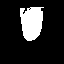

In [0]:
toPIL(test_labels[3])

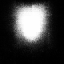

In [0]:
toPIL(prediction[3])